# PNAI-Conditioned Atmospheric River Occurrence Anomaly Composites

This code creates anomaly composites for anomalous ERA5 atmospheric river occurrences in the extended boreal winter period, 1986/87-2015/16, over the Pacific North America region, based on the index for the Pacific North American teleconnection pattern.

* Input: `/glade/work/mkorendy/clim680/pna.data`
* Input: `/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.NDJFM.anoms.nc`

1. Take the monthly average of AR anomalies
2. Identify times of positive and negative PNA phases
3. Select AR anomalies for these times
4. Create composites of the AR anomalies for the positive and negative PNA phases.

* Output: `era5.AR.10%.PNA.NDJFM.PNA_phase.png`

## Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

## Files

In [2]:
# Path
path = '/glade/work/mkorendy/'

# PNA input
f_pna = path + 'clim680/pna.data'

# ERA5 AR anomaly input
f_ar = path + 'metisregimes/era5.AR.10%.PNA.NDJFM.anoms.nc'

#Output:
f_pos = 'era5.AR.10%.PNA.NDJFM.PNA_positive.png'
f_neg = 'era5.AR.10%.PNA.NDJFM.PNA_negative.png'

In [3]:
print(f_pna)
print(f_ar)

/glade/work/mkorendy/clim680/pna.data
/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.NDJFM.anoms.nc


## Read in data

In [4]:
# PNA data
df_pna = pd.read_table(f_pna,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df_pna.drop(df_pna.tail(3).index,inplace=True)

### Convert PNA data from dataframe to dataset

In [5]:
# Get time stamps for dataset
start_date=str(df_pna.index[0])+'-'+str(df_pna.columns[0])+'-01'
end_date=str(df_pna.index[-1])+'-'+str(df_pna.columns[-1])+'-01'

dates=pd.date_range(start=start_date,end=end_date,freq='MS')

# Turn dataframe into array
pna_index=df_pna.T.unstack().values

# Turn array into dataset
ds_pna=xr.DataArray(pna_index,
                      coords={'time':dates},
                              dims=['time']).to_dataset(name='pna')
#ds_pna

In [6]:
# ERA5 AR anomaly data
ds_ar = xr.open_dataset(f_ar)
#ds_ar

In [7]:
max(ds_ar.river.values.flatten())

1.0007350651163969

## Monthly means of ERA5 AR anomalies, and NDJFM 1986-2016 PNA values

In [8]:
# List of monthly means per year over all years
ls_ar = []

# List of PNA indices for 1986-2016 NDJFM
ls_pna = []

# For each year, calculate monthly means
# And append to the list of monthly means per year
for yr in np.arange(1986,2016):
    ls_ar.append(ds_ar.sel(time=slice(str(yr) + '-11', str(yr+1) + '-04')).groupby('time.month').mean())
    ls_pna.append(ds_pna.sel(time=slice(str(yr) + '-11', str(yr+1) + '-03')))

# Concatenate the datasets together
ds_ar_means = xr.concat(ls_ar, dim='year')
ds_pna_index = xr.concat(ls_pna, dim='time')

# Reshape AR mean dataset by collapsing years and months together
ds_ar_means = xr.DataArray(ds_ar_means.river.values.reshape(len(ds_ar_means.year)*len(ds_ar_means.month),22,53),
                coords={'time':ds_pna_index.time, 'lat':ds_ar_means.lat, 'lon':ds_ar_means.lon},
                dims=['time','lat','lon']).to_dataset(name = 'river')

In [9]:
#ds_pna_index

In [10]:
#ds_ar_means

## Identify positive and negative phases of PNA

In [11]:
# Convert pna to float
ds_pna_index = ds_pna_index.astype(float)

In [12]:
ds_positive = (ds_pna_index.where(ds_pna_index.pna < -1)).dropna('time').time
ds_negative = (ds_pna_index.where(ds_pna_index.pna > 1)).dropna('time').time

## Get AR anomaly composites for negative and positive phases of PNA

In [13]:
ds_ar_pos = ds_ar_means.sel(time=ds_positive.time).mean('time')
ds_ar_neg = ds_ar_means.sel(time=ds_negative.time).mean('time')

In [14]:
#ds_ar_pos

In [15]:
#ds_ar_neg

## Plot the positive and negative composites

In [16]:
# Color levels
levs = np.arange(-.006,.007,.001)

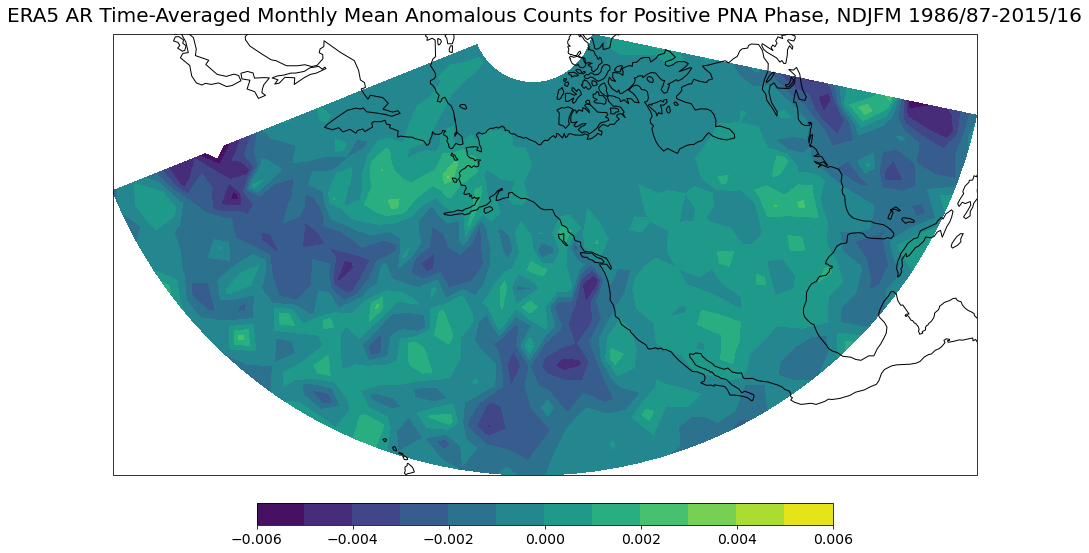

In [17]:
cm = 220

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

# Set the axes using the specified map projection
fig,axs=plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(20,15))

cs = axs.contourf(ds_ar_pos['lon'], ds_ar_pos['lat'], ds_ar_pos['river'], levs, transform=ccrs.PlateCarree())
axs.coastlines()
cbar_ax = fig.add_axes([0.3, 0.5, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
fig.subplots_adjust(bottom=0, top=1.5, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
plt.suptitle('ERA5 AR Time-Averaged Monthly Mean Anomalous Counts for Positive PNA Phase, NDJFM 1986/87-2015/16' ,fontsize=20)
plt.savefig(f_pos)

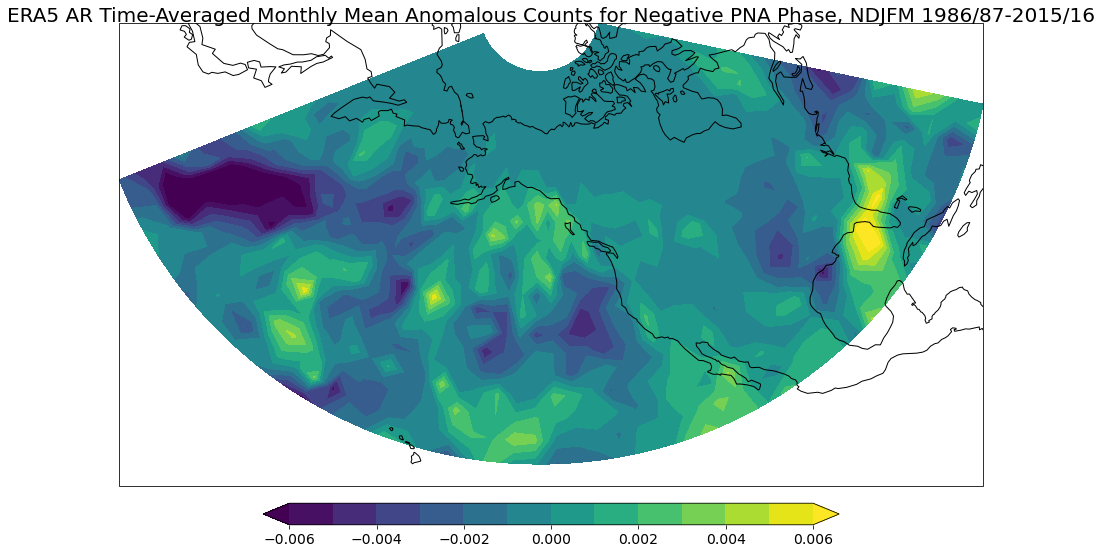

In [18]:
cm = 220

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

# Set the axes using the specified map projection
fig,axs=plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(20,15))

cs = axs.contourf(ds_ar_pos['lon'], ds_ar_pos['lat'], ds_ar_neg['river'], levs, 
                  transform=ccrs.PlateCarree(), extend='both')
axs.coastlines()
cbar_ax = fig.add_axes([0.3, 0.5, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
fig.subplots_adjust(bottom=0, top=1.5, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
plt.suptitle('ERA5 AR Time-Averaged Monthly Mean Anomalous ' +  
             'Counts for Negative PNA Phase, NDJFM 1986/87-2015/16' ,fontsize=20)
plt.savefig(f_neg)